![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)

# Full-Featured Agent Architecture
The following example demonstrates how to build a tool-enabled agentic workflow with a semantic cache and an allow/block list router. This approach helps reduce latency and costs in the final solution.

Note: This notebook summarizes this [this workshop](https://github.com/redis-developer/oregon-trail-agent-workshop). For a more detailed step-by-step walkthrough of each element, please refer to the repository.

## Let's Begin!
<a href="https://colab.research.google.com/github/redis-developer/redis-ai-resources/blob/main/python-recipes/agents/02_full_featured_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Packages

In [1]:
%pip install -q langchain langchain-openai "langchain-redis>=0.2.0" langgraph sentence-transformers

### OPEN_AI_API key

A open_ai_api key with billing information enabled is required for this lesson.

In [1]:
# NBVAL_SKIP
import os
import getpass



def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ········


## Redis instance

### For colab

In [3]:
# NBVAL_SKIP
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


gpg: cannot open '/dev/tty': No such device or address
curl: (23) Failed writing body


#### For Alternative Environments
There are many ways to get the necessary redis-stack instance running
1. On cloud, deploy a [FREE instance of Redis in the cloud](https://redis.com/try-free/). Or, if you have your
own version of Redis Enterprise running, that works too!
2. Per OS, [see the docs](https://redis.io/docs/latest/operate/oss_and_stack/install/install-stack/)
3. With docker: `docker run -d --name redis-stack-server -p 6379:6379 redis/redis-stack-server:latest`

## Test connection

In [2]:
import os
from redis import Redis

# Use the environment variable if set, otherwise default to localhost
REDIS_URL = os.getenv("REDIS_URL", "redis://localhost:6379")

client = Redis.from_url(REDIS_URL)
client.ping()

True

# Motivation

The goal of the workshop is to create an agent workflow that can handle five Oregon Trail-themed scenarios, mimicking situations that often arise when implementing agent workflows in practice.

## Scenario 1 - name of the wagon leader

**Learning goal:** Test basic LangGraph setup and execution. <br>

**Question:** `What is the first name of the wagon leader?` <br>
**Answer:** `Art` <br>
**Type:** `free-form` <br>

## Scenario 2 - restocking tool

**Learning goal:** Agent interaction with custom defined tool and **structured output** for multiple choice questions. <br>

**Question:** `In order to survive the trail ahead, you'll need to have a restocking strategy for when you need to get more supplies or risk starving. If it takes you an estimated 3 days to restock your food and you plan to start with 200lbs of food, budget 10lbs/day to eat, and keep a safety stock of at least 50lbs of back up... at what point should you restock?` <br>
**Answer:** `D` <br>
**Options:** `["A: 100lbs", "B: 20lbs", "C: 5lbs", "D: 80lbs"]` <br>
**Type:** `multi-choice` <br>

## Scenario 3 - retrieval tool

**Learning goal:** Agent implements Retrieval Augmented Generation.

**Question:** `You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?` <br>
**Answer:** `B` <br>
**Options:** `["A: take the northern trail", "B: take the southern trail", "C: turn around", "D: go fishing"]` <br>
**Type:** `multi-choice` <br>

## Scenario 4 - semantic cache

**Learning goal:** Implement semantic cache that bypasses expensive agent workflow for known answer. <br>

**Question:** `There's a deer. You're hungry. You know what you have to do...` <br>
**Answer:** `bang` <br>
**Type:** `free-form` <br>

## Scenario 5 - allow/block list with router

**Learning goal:** Implement semantic router that blocks requests for non-related topics.

**Question:** `Tell me about the S&P 500?` <br>
**Answer:** `you shall not pass` <br>
**Type:** `free-form` <br>



# Final Architecture

In the end, we are building a workflow like the following:

![diagram](../../assets/full_featured_agent.png)

As a reminder for more detail see: [Redis Developer Oregon Trail Agent Workshop](https://github.com/redis-developer/oregon-trail-agent-workshop).

# Defining the agent with LangGraph

## Tools

Tools are functions that the central LLM powered "agent" can determine to invoke depending on the situation.

### Restock tool

The first tool we will define implements the restocking formula. LLMs are designed to predict text responses, not to perform deterministic math. In this case, the agent will act as a parser, extracting the necessary information from the human query and calling the tool with the appropriate schema.

One of the advantages of `LangGraph` is that the schema for the tool can be defined as a `pydantic` model. Note: It is also essential to include a well-written `doc_string` with the tool function so the agent can determine the appropriate situation to use the tool.

In [3]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class RestockInput(BaseModel):
    daily_usage: int = Field(
        description="Pounds (lbs) of food expected to be consumed daily"
    )
    lead_time: int = Field(description="Lead time to replace food in days")
    safety_stock: int = Field(
        description="Number of pounds (lbs) of safety stock to keep on hand"
    )


@tool("restock-tool", args_schema=RestockInput)
def restock_tool(daily_usage: int, lead_time: int, safety_stock: int) -> int:
    """restock formula tool used specifically for calculating the amount of food at which you should start restocking."""
    print(f"\n Called restock tool: {daily_usage=}, {lead_time=}, {safety_stock=} \n")
    return (daily_usage * lead_time) + safety_stock

## Retriever tool

Sometimes an LLM might need access to data that it was not trained on, whether because the data is proprietary, time-sensitive, or otherwise unavailable.

In such cases, Retrieval-Augmented Generation (RAG) is often necessary. Here, a vector search is used to augment the final LLM prompt with helpful and necessary context.

RAG and agents are not mutually exclusive. Below, we define a retriever tool that performs RAG whenever the agent determines it is necessary.

In [4]:
from langchain.tools.retriever import create_retriever_tool

from langchain_redis import RedisConfig, RedisVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


In [8]:
## Helper methods

INDEX_NAME = os.environ.get("VECTOR_INDEX_NAME", "oregon_trail")
REDIS_URL = os.environ.get("REDIS_URL", "redis://localhost:6379/0")

CONFIG = RedisConfig(index_name=INDEX_NAME, redis_url=REDIS_URL)
display(CONFIG)

RedisConfig(index_name='oregon_trail', from_existing=False, key_prefix='oregon_trail', redis_url='redis://localhost:6379/0', redis_client=None, connection_args={}, distance_metric='COSINE', indexing_algorithm='FLAT', vector_datatype='FLOAT32', storage_type='hash', id_field='id', content_field='text', embedding_field='embedding', default_tag_separator='|', metadata_schema=[], index_schema=None, schema_path=None, return_keys=False, custom_keys=None, embedding_dimensions=None, legacy_key_format=True)

In [9]:
def get_vector_store():
    try:
        CONFIG.from_existing = True
        vector_store = RedisVectorStore(OpenAIEmbeddings(), config=CONFIG)
    except:
        print("Init vector store with document")
        CONFIG.from_existing = False
        vector_store = RedisVectorStore.from_documents(
            [doc], OpenAIEmbeddings(), config=CONFIG
        )
    return vector_store

## Relevant data
"""
the northern trail, of the blue mountains, was destroyed by a flood and is no longer safe to traverse. 
It is recommended to take the southern trail although it is longer.
"""

doc = Document(
    page_content="the northern trail, of the blue mountains, was destroyed by a flood and is no longer safe to traverse. It is recommended to take the southern trail although it is longer."
)

## Retriever tool
vector_store = get_vector_store()

retriever_tool = create_retriever_tool(
    vector_store.as_retriever(),
    "get_directions",
    "Search and return information related to which routes/paths/trails to take along your journey.",
)

## Store both tools in a list
tools = [retriever_tool, restock_tool]

20:07:47 httpx INFO   HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Init vector store with document
20:07:48 httpx INFO   HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


# State

State is the set of messages that is passed between nodes in our graph so that the proceeding node knows what happened at the last node and so on. In this case, our state will extend the normal `MessageState` but also add a custom field for `multi_choice_responses`. 

In [10]:
from typing import Literal

from langgraph.graph import MessagesState
from pydantic import BaseModel, Field


class MultipleChoiceResponse(BaseModel):
    multiple_choice_response: Literal["A", "B", "C", "D"] = Field(
        description="Single character response to the question for multiple choice questions. Must be either A, B, C, or D."
    )


class AgentState(MessagesState):
    multi_choice_response: MultipleChoiceResponse


# Nodes

Nodes are steps in the process flow of our agent where functions can be invoked.

In [11]:
from functools import lru_cache

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode


## Function definitions that invoke an LLM model

### with tools
@lru_cache(maxsize=4)
def _get_tool_model(model_name: str):
    if model_name == "openai":
        model = ChatOpenAI(temperature=0, model_name="gpt-4o")
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    model = model.bind_tools(tools)
    return model

### with structured output
@lru_cache(maxsize=4)
def _get_response_model(model_name: str):
    if model_name == "openai":
        model = ChatOpenAI(temperature=0, model_name="gpt-4o")
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    model = model.with_structured_output(MultipleChoiceResponse)
    return model

### Functions for responding to a multiple choice question
def multi_choice_structured(state: AgentState, config):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    model_name = config.get("configurable", {}).get("model_name", "openai")

    print("Called multi choice structured")

    response = _get_response_model(model_name).invoke(
        [
            HumanMessage(content=state["messages"][0].content),
            HumanMessage(content=f"Answer from tool: {state['messages'][-2].content}"),
        ]
    )
    # We return the final answer
    return {
        "multi_choice_response": response.multiple_choice_response,
    }


# Function for conditional edge
def is_multi_choice(state: AgentState):
    return "options:" in state["messages"][0].content.lower()


def structure_response(state: AgentState, config):
    if is_multi_choice(state):
        return multi_choice_structured(state, config)
    else:
        # if not multi-choice don't need to do anything
        return {"messages": []}


system_prompt = """
    You are an oregon trail playing tool calling AI agent. 
    Use the tools available to you to answer the question you are presented. 
    When in doubt use the tools to help you find the answer.
    If anyone asks your first name is Art return just that string.
"""


# Define the function that calls the model
def call_tool_model(state: AgentState, config):
    # Combine system prompt with incoming messages
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    # Get from LangGraph config
    model_name = config.get("configurable", {}).get("model_name", "openai")

    # Get our model that binds our tools
    model = _get_tool_model(model_name)

    # invoke the central agent/reasoner with the context of the graph
    response = model.invoke(messages)

    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
tool_node = ToolNode(tools)


# Graph

The graph composes the tools and nodes into a compilable workflow that can be invoked.

In [12]:
from typing import Literal, TypedDict
from langgraph.graph import END, StateGraph


# Define the config
class GraphConfig(TypedDict):
    model_name: Literal["anthropic", "openai"]

# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "structure_response"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState, config_schema=GraphConfig)

# Add nodes
workflow.add_node("agent", call_tool_model)
workflow.add_node("tools", tool_node)
workflow.add_node("structure_response", structure_response)

# Set the entrypoint
workflow.set_entry_point("agent")

# add conditional edge between agent and tools
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"continue": "tools", "structure_response": "structure_response"},
)


# We now add a normal edge from `tools` to `agent`.
workflow.add_edge("tools", "agent")
workflow.add_edge("structure_response", END)


# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
graph = workflow.compile()


# Evaluate graph structure

When we invoke the graph, it follows four primary steps:  

1. **Evaluate Conditional Edge**: The graph evaluates the conditional edge between tools and the agent via the `should_continue` function. This determines whether it should `continue` and call a tool or move to `structure_response` to format the output for the user.  
2. **Invoke Tools**: If it decides to invoke the tools, the response from the tool is appended as a message to the state and passed back to the agent.  
3. **Determine Next Step**: If tools have already been called or are deemed unnecessary, the graph moves to the `structure_response` node.  
4. **Handle Multiple-Choice Questions**: If the question is identified as a **multiple-choice question** within the `structure_response` node, a model is invoked to ensure the response is returned as a literal `A, B, C, or D`, as expected by the game. Otherwise, it simply proceeds forward.  

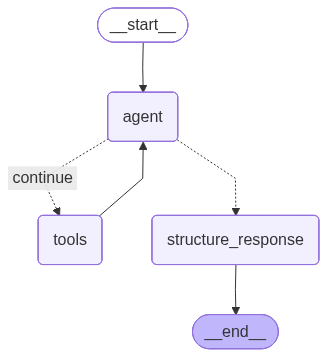

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Run scenarios

Note: LLMs are fundamentally probabilistic so wrong answers are possible even if implemented correctly.

## Scenario 1 - name of wagon leader

This test confirms that our graph has been setup correctly and can handle a case where tools don't need to be invoked.

In [14]:
scenario = {
    "question": "What is the first name of the wagon leader?",
    "answer": "Art",
    "type": "free-form",
}

print(f"\n Question: {scenario['question']} \n")

res = graph.invoke({"messages": scenario["question"]})

print(f"\n Agent response: {res['messages'][-1].content}\n")

assert res["messages"][-1].content == scenario["answer"]


 Question: What is the first name of the wagon leader? 

20:14:46 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

 Agent response: Art



In [15]:
res

{'messages': [HumanMessage(content='What is the first name of the wagon leader?', additional_kwargs={}, response_metadata={}, id='7dfc1edc-6c87-4e34-98e3-c2363d1b16f6'),
  AIMessage(content='Art', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 216, 'total_tokens': 218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CVo7q7cgjGy7H1kIqZjL09VzvCGsR', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3c562cc8-e156-4a41-acd0-ac1e5f642214-0', usage_metadata={'input_tokens': 216, 'output_tokens': 2, 'total_tokens': 218, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## Scenario 2 - restocking tool

In this test we want to see the agent choose the restocking tool and choose to use the multiple choice output.

In [16]:
# helper function for multi-choice questions
def format_multi_choice_question(q):
    question = q["question"]
    options = q.get("options", "")
    formatted = f"{question}, options: {' '.join(options)}"
    print(f"TEST: {[HumanMessage(content=formatted)]}")
    return [HumanMessage(content=formatted)]

scenario = {
        "question": "In order to survive the trail ahead, you'll need to have a restocking strategy for when you need to get more supplies or risk starving. If it takes you an estimated 3 days to restock your food and you plan to start with 200lbs of food, budget 10lbs/day to eat, and keep a safety stock of at least 50lbs of back up... at what point should you restock?",
        "answer": "D",
        "options": ["A: 100lbs", "B: 20lbs", "C: 5lbs", "D: 80lbs"],
        "type": "multi-choice",
    }

print(f"\n Question: {scenario['question']} \n")

res = graph.invoke({"messages": format_multi_choice_question(scenario)})

print(f"\n Agent response: {res['multi_choice_response']}")

assert res["multi_choice_response"] == scenario["answer"]



 Question: In order to survive the trail ahead, you'll need to have a restocking strategy for when you need to get more supplies or risk starving. If it takes you an estimated 3 days to restock your food and you plan to start with 200lbs of food, budget 10lbs/day to eat, and keep a safety stock of at least 50lbs of back up... at what point should you restock? 

TEST: [HumanMessage(content="In order to survive the trail ahead, you'll need to have a restocking strategy for when you need to get more supplies or risk starving. If it takes you an estimated 3 days to restock your food and you plan to start with 200lbs of food, budget 10lbs/day to eat, and keep a safety stock of at least 50lbs of back up... at what point should you restock?, options: A: 100lbs B: 20lbs C: 5lbs D: 80lbs", additional_kwargs={}, response_metadata={})]
20:15:31 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

 Called restock tool: daily_usage=10, lead_time=3, safety_s

## Scenario 3 - retriever tool

In this test, we want to see the retrieval tool invoked and multiple choice structured response.

In [17]:
scenario = {
        "question": "You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?",
        "answer": "B",
        "options": [
            "A: take the northern trail",
            "B: take the southern trail",
            "C: turn around",
            "D: go fishing",
        ],
        "type": "multi-choice",
    }

print(f"\n Question: {scenario['question']} \n")

res = graph.invoke({"messages": format_multi_choice_question(scenario)})

print(f"\n Agent response: {res['multi_choice_response']}")

assert res["multi_choice_response"] == scenario["answer"]


 Question: You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go? 

TEST: [HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={})]
20:16:10 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
20:16:12 httpx INFO   HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
20:16:13 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Called multi choice structured
20:16:14 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

 Agent response: B


## Scenario 4 - Semantic caching

Agent workflows are highly flexible and capable of handling a wide range of scenarios, but this flexibility comes at a cost. Even in our simple example, there can be multiple large-context LLM calls in the same execution, leading to high latency and increased service costs by the end of the month.<br>

A good practice is to cache answers to known questions. Chatbot interactions are often fairly predictable, particularly in support or FAQ-type use cases, making them excellent candidates for caching.


![diagram](../../assets/cache_diagram.png)

## Creating a cache

In [19]:
import warnings
from redisvl.extensions.llmcache import SemanticCache
warnings.filterwarnings("ignore")

hunting_example = "There's a deer. You're starving. You know what you have to do..."

semantic_cache = SemanticCache(
    name="oregon_trail_cache",
    redis_url=REDIS_URL,
    distance_threshold=0.1,
)

semantic_cache.store(prompt=hunting_example, response="bang")

20:19:03 sentence_transformers.SentenceTransformer INFO   Use pytorch device_name: mps
20:19:03 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: redis/langcache-embed-v1


'oregon_trail_cache:602ac35f09671fc9e2a4f4902c6f82f06b9560ea6b5a5dd3e9218fcc1ff47e52'

## Testing the cache

In [20]:
import time

scenarios = [
    {
        "question": "There's a deer. You're hungry. You know what you have to do...",
        "answer": "bang",
        "type": "cache_hit",
    },
    {
        "question": "You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?",
        "answer": "B",
        "options": [
            "A: take the northern trail",
            "B: take the southern trail",
            "C: turn around",
            "D: go fishing",
        ],
        "type": "multi-choice",
    }
]

for scenario in scenarios:
    print(f"\n Question: {scenario['question']} \n")

    start = time.time()

    cache_hit = semantic_cache.check(prompt=scenario["question"], return_fields=["response"])

    if not cache_hit:
        print("Invoking agent")
        res = graph.invoke({"messages": format_multi_choice_question(scenario)})
    else:
        
        print(f"Cache hit: {cache_hit}")

    response_time = time.time() - start

    print(f"Response time {response_time}s")


 Question: There's a deer. You're hungry. You know what you have to do... 

Cache hit: [{'response': 'bang', 'key': 'oregon_trail_cache:602ac35f09671fc9e2a4f4902c6f82f06b9560ea6b5a5dd3e9218fcc1ff47e52'}]
Response time 0.057869911193847656s

 Question: You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go? 

Invoking agent
TEST: [HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={})]
20:19:35 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
20:19:36 httpx INFO   HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
20:

## Scenario 5 - Allow/block list router

When ChatGPT first launched, there was a famous example where a car dealership accidentally made one of the latest language models available for free to everyone. They assumed users would only ask questions about cars through their chatbot. However, a group of developers quickly realized that the model was powerful enough to answer coding questions, so they started using the dealership's chatbot for free. <br>

To prevent this kind of misuse in your system, adding an allow/block router to the front of your application is essential. Fortunately, this is very easy to implement using `redisvl`.

![diagram](../../assets/router_diagram.png)

## Creating the router

In [21]:
from redisvl.extensions.router import Route, SemanticRouter

# Semantic router
blocked_references = [
    "thinks about aliens",
    "corporate questions about agile",
    "anything about the S&P 500",
]

blocked_route = Route(name="block_list", references=blocked_references)

router = SemanticRouter(
    name="bouncer",
    routes=[blocked_route],
    redis_url=REDIS_URL,
    overwrite=False,
)

20:20:18 sentence_transformers.SentenceTransformer INFO   Use pytorch device_name: mps
20:20:18 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


## Testing the router

In [22]:
scenario = {
        "question": "Tell me about the S&P 500?",
        "answer": "you shall not pass",
        "type": "action",
    }

print(f"\n Question: {scenario['question']} \n")

blocked_topic_match = router(scenario["question"], distance_threshold=0.2)

assert blocked_topic_match.name == "block_list"

print("Blocked!")


 Question: Tell me about the S&P 500? 

Blocked!


## Putting it all together

Once you have defined all the pieces, connecting the various aspects of the full architecture becomes easy and you can tie them together with whatever logic you wish. 

This could be as simple as:

In [23]:
def respond_to_question(question):
    blocked_topic_match = router(question, distance_threshold=0.2)

    if blocked_topic_match.name == "block_list":
        print("App block logic - short circuit")
        return

    cache_hit = semantic_cache.check(prompt=question, return_fields=["response"])

    if cache_hit:
        print("Cache hit - short circuit")
        return cache_hit
    
    return graph.invoke({"messages": question})
